In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer
from skimage.color import rgb2gray
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Dropout, TimeDistributed, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, Callback

ModuleNotFoundError: No module named 'pandas'

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    fo.close()
    return dict

In [3]:
def get_image(image_data):
    split_color = 1024
    colors = {}
    # get red (0), green (1), blue (2) and create three 1024 arrays
    for i in range(0, 3):
        colors[i] = image_data[i*split_color:(i+1)*split_color]

    # convert each of the rgb vectors into a 1024x3 array 
    rgb_list = []
    for i in range(0, split_color):
        rgb_temp = []
        for k in range(0, 3):
            rgb_temp.append(colors[k][i])
        rgb_list.append(rgb_temp)

    # convert the rgb pixels into a 32x32x3 array
    image_list = []
    for i in range(0, 32):
        image_list.append(rgb_list[i*32: (i+1)*32])
    return image_list

In [16]:
def predictImage(image, centers_dict, kmeans):
    return_image_rgb = []
    return_image_hot = []
    for i in range(0,32):
        color_pred = list(kmeans.predict(image[i]))
        
        return_rgb = [centers_dict[x] for x in color_pred]
        return_hot = [one_hot_dict[x] for x in color_pred]
        
        return_image_rgb.append(return_rgb)
        return_image_hot.append(return_hot)
    return np.array(return_image_rgb), np.array(return_image_hot)

# Extract Train and Test Batches

In [4]:
train_data_dict = {}
train_label_dict = {}
path = '../Data/images/'
for i in range(1, 6):
    file_name = 'data_batch_' + str(i)
    batch = unpickle(path + file_name)
    train_data_dict[file_name] = batch[b'data']
    train_label_dict[file_name] = batch[b'labels']

In [5]:
batch = unpickle(path + 'test_batch')
test_data = batch[b'data']
test_label = batch[b'labels']

We want to limit our training experimentation to just batch 1 to begin.

In [6]:
batch1_raw = train_data_dict['data_batch_1']

# Convert to RGB (32x32x3)

In [7]:
# convert our image into a 32x32x3 RGB image
train_images = []
for image in tqdm(batch1_raw):
    train_images.append(np.array(get_image(image)))

test_images = []
for image in tqdm(test_data):
    test_images.append(np.array(get_image(image)))

100%|██████████| 10000/10000 [00:07<00:00, 1417.85it/s]


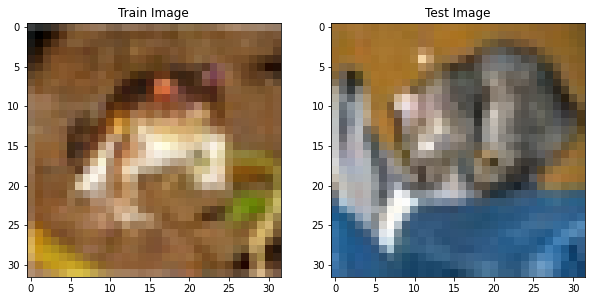

In [8]:
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(train_images[0], interpolation='nearest', cmap='gray')
ax[0].title.set_text('Train Image')

ax[1].imshow(test_images[0], interpolation='nearest', cmap='gray')
ax[1].title.set_text('Test Image')

# Obtain Centroid RGB Pixels (using KMeans)

### Process Sample

In [9]:
pixels_all = []

for l in tqdm(range(0, len(train_images))):
    for i in range(0,32):
        for k in range(0,32):
            pixels_all.append(tuple(train_images[l][i][k]))

100%|██████████| 10000/10000 [00:05<00:00, 1808.89it/s]


In [10]:
pixels_all = set(pixels_all)
pixels_all = [list(x) for x in pixels_all]

In [11]:
# sample pixels
len_pixels = len(pixels_all)
len_pixels_sample = int(len_pixels*.3)

sel_indices = random.sample(range(0, len_pixels), len_pixels_sample)
pixels_sample = [pixels_all[x] for x in sel_indices]

### Run KMeans

In [12]:
k = 20

In [13]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(pixels_sample)

KMeans(n_clusters=20)

In [14]:
# map the centroid pixels
centers_dict = {}
for i in range(0,k):
    centers_dict[i] = [int(np.round(x)) for x in kmeans.cluster_centers_[i]]

In [15]:
# initialize mapping to one hot
knn_outputs = range(len(centers_dict))
lb = LabelBinarizer()
one_hot = lb.fit_transform(knn_outputs)
one_hot_dict = {}
for k in knn_outputs:
    one_hot_dict[k] = list(one_hot[k])

# Convert RGBs to Nearest Centroid RGB

In [17]:
train_images_knn_rgb = []
train_images_knn_hot = []
for image in tqdm(train_images):
    return_image_rgb, return_image_hot = predictImage(image, centers_dict, kmeans)
    train_images_knn_rgb.append(return_image_rgb)
    train_images_knn_hot.append(return_image_hot)

100%|██████████| 10000/10000 [01:42<00:00, 97.65it/s]


In [18]:
test_images_knn_rgb = []
test_images_knn_hot = []
for image in tqdm(test_images):
    return_image_rgb, return_image_hot = predictImage(image, centers_dict, kmeans)
    test_images_knn_rgb.append(return_image_rgb)
    test_images_knn_hot.append(return_image_hot)

100%|██████████| 10000/10000 [01:45<00:00, 94.93it/s] 


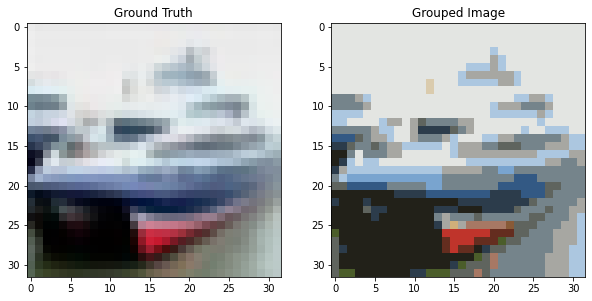

In [20]:
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(test_images[1], interpolation='nearest', cmap='gray')
ax[0].title.set_text('Ground Truth')

ax[1].imshow(test_images_knn_rgb[1], interpolation='nearest', cmap='gray')
ax[1].title.set_text('Grouped Image')

# Get X Features (GrayScaled)

In [25]:
train_images_grayscale = []
for image in train_images:
    train_images_grayscale.append(rgb2gray(image))

In [26]:
test_images_grayscale = []
for image in test_images:
    test_images_grayscale.append(rgb2gray(image))

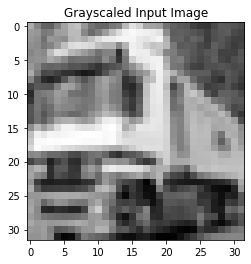

In [29]:
plt.title('Grayscaled Input Image')
plt.imshow(train_images_grayscale[1], interpolation='nearest', cmap='gray')

# Model Training

In [30]:
# grayscale inputs
x_train_gray = np.array(train_images_grayscale).reshape(-1,32,32,1)
x_test_gray = np.array(test_images_grayscale).reshape(-1,32,32,1)

In [31]:
# KNN colors flat
y_train_knn = np.array(train_images_knn_hot).reshape(-1,4096)
y_test_knn = np.array(test_images_knn_hot).reshape(-1,4096)

In [34]:
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32,32,1), padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))

model.add(Activation('softmax'))

In [68]:
num_epochs = 30

In [69]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [70]:
model_results = model.fit(x_train_gray, y_train_knn, validation_split=0.2, 
                          epochs=num_epochs, batch_size=32)

Epoch 1/30
250/250 [==============================] - 43s 159ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/30
250/250 [==============================] - 40s 159ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/30
250/250 [==============================] - 41s 163ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/30
250/250 [==============================] - 44s 176ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/30
250/250 [==============================] - 45s 179ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/30
250/250 [==============================] - 41s 166ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/30
250/250 [==============================] - 41s 163ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/30
250/250 [==============================] - 38s 153ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/30
250/250 [==============================] - 39s 157ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/30
250/250 [==============================] - 44s 177ms/step - l

# Visualize Outputs

In [71]:
first_10_test = model.predict(x_test_gray[0:10]).reshape(-1,32,32,4)

In [73]:
def encodeToRGB(output):
    out_print = []
    for i in range(0,32):
        temp = []
        for k in range(0, 32):
            temp.append(centers_dict[np.argmax(output[i][k])])
        out_print.append(temp)
    out_print = np.array(out_print)
    return out_print

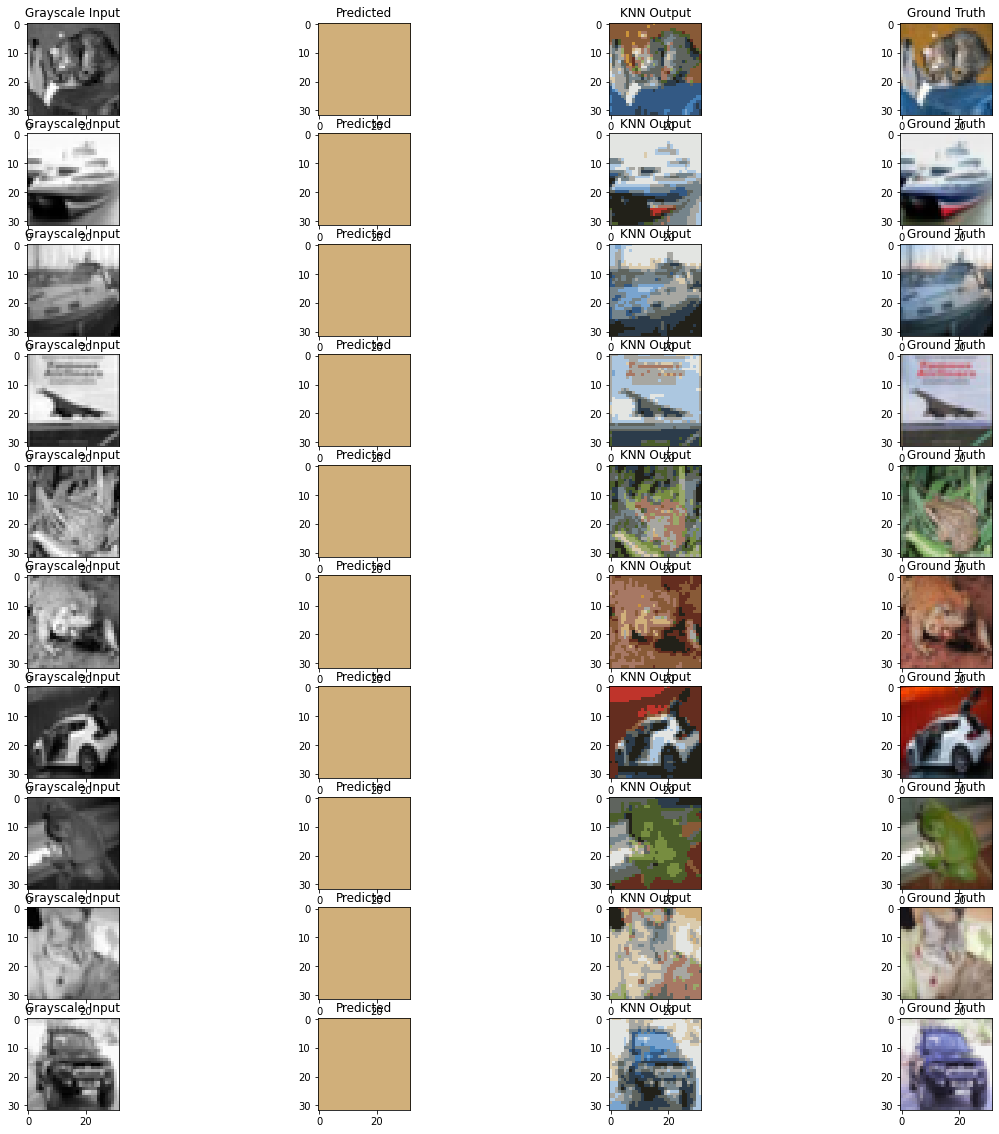

In [74]:
first_10_color = []
f, axarr = plt.subplots(10,4, figsize=(20,20))
for index, image in enumerate(first_10_test):
    first_10_color.append(encodeToRGB(image))
    axarr[index, 0].imshow(test_images_grayscale[index], interpolation='nearest', cmap='gray')
    axarr[index, 0].title.set_text('Grayscale Input')
    
    axarr[index, 1].imshow(first_10_color[index], interpolation='nearest')
    axarr[index, 1].title.set_text('Predicted')
    
    axarr[index, 2].imshow(test_images_knn_rgb[index], interpolation='nearest')
    axarr[index, 2].title.set_text('KNN Output')
    
    axarr[index, 3].imshow(test_images[index], interpolation='nearest')
    axarr[index, 3].title.set_text('Ground Truth')